Some more EDA a bit different than Project_collab, and other EDA_ files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
import plotly.express as px

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1i-JbDm2nY15NnYl62GxlsBCoELp1HJZ3")

# Correlation feature importance

In [ ]:
cancel_corr = df.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In these numerical features, we can see the important ones on top ordered in ascending.

In [ ]:
df.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

# Other EDA

## Countries

In [ ]:
countries = pd.DataFrame(df.loc[df["is_canceled"] == 0]["country"].value_counts())
countries.rename(columns={"country": "Guests"}, inplace=True)
total_guests = countries["Guests"].sum()
countries["Percentage"] = round(countries["Guests"] / total_guests * 100, 2)
countries["country"] = countries.index
fig = px.pie(countries, values="Guests", names="country", title="Origin", template="seaborn")
fig.update_traces(textposition="inside")
fig.show()

In [ ]:
world = px.choropleth(
    countries,
    locations=countries.index,
    color=countries["Percentage"],
    hover_name=countries.index, 
    color_continuous_scale=px.colors.sequential.Viridis,
    title="Origin"
)
world.show()

In [ ]:
city = df.loc[df['hotel'] == "City Hotel"]
resort = df.loc[df['hotel'] == 'Resort Hotel']
resort["per_person"] = resort["adr"] / (resort["adults"] + resort["children"])
# city["per_person"] = city["adr"] / (city["adults"] + city["children"])
# city['per_person'] = city['per_person'].replace([np.inf, -np.inf], np.nan)
# city = city.dropna(subset=['per_person']).reset_index(drop=True)
# resort['per_person'] = resort['per_person'].replace([np.inf, -np.inf], np.nan)
# resort = resort.dropna(subset=['per_person']).reset_index(drop=True)

# print('\nMean princing per person:\n')
# print(f'City hotels: ${city["per_person"].dropna().mean()}')
# print(f'Resorts: ${resort["per_person"].dropna().mean()}')


Mean princing per person:

City hotels: $58.49014354442745
Resorts: $48.48037508011421


<ipython-input-131-5f3f953af430>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-131-5f3f953af430>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-131-5f3f953af430>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-131-5f3

In [ ]:
def show_yearly_price_fluc(source, hotel_type):
  print(f'\nHotel type: {hotel_type}')

  cols = ["hotel", "arrival_date_month", "per_person"]
  prices = source[cols].sort_values("arrival_date_month")
  months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
  prices["arrival_date_month"] = pd.Categorical(prices["arrival_date_month"], categories=months, ordered=True)

  plt.figure(figsize=(12, 8))
  sns.lineplot(data=prices, x="arrival_date_month", y="per_person", sizes=(10, 6))
  plt.title("Price/night through the year", fontsize=16)
  plt.xlabel("Month", fontsize=16)
  plt.xticks(rotation=45)
  plt.ylabel("Price", fontsize=16)
  plt.show()


Hotel type: City


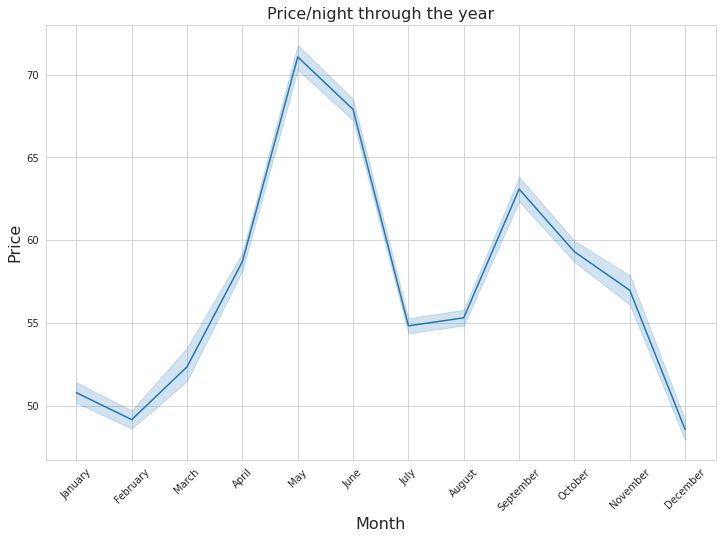


Hotel type: Resort


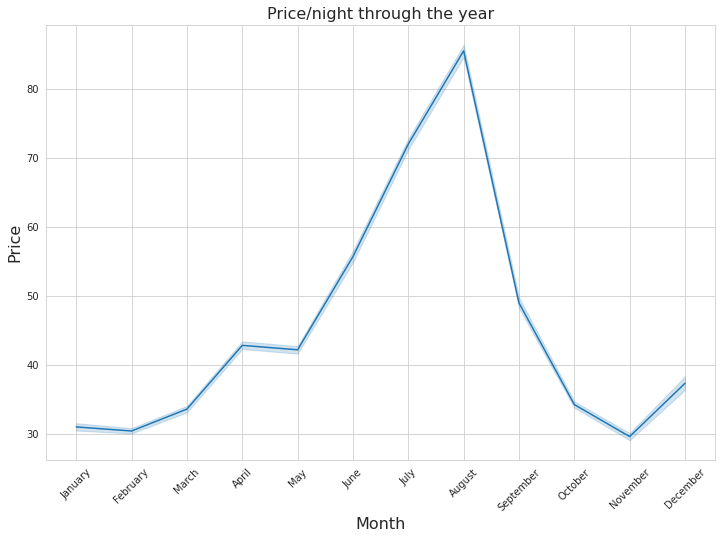

In [ ]:
show_yearly_price_fluc(city, 'City')
show_yearly_price_fluc(resort, 'Resort')

In [ ]:
def show_yearly_cancellation_ratio(source, hotel_type):
    print(f'\nHotel type: {hotel_type}')
    
    cols = ["hotel", "arrival_date_month", "is_canceled"]
    data = source[cols].sort_values("arrival_date_month")
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    data["arrival_date_month"] = pd.Categorical(data["arrival_date_month"], categories=months, ordered=True)
    ratio = data.groupby("arrival_date_month")["is_canceled"].mean() * 100
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=ratio, x=ratio.index, y=ratio.values, sizes=(10, 6))
    plt.title("Cancellation ratio per month", fontsize=16)
    plt.xlabel("Month", fontsize=16)
    plt.xticks(rotation=45)
    plt.ylabel("Cancellation ratio (%)", fontsize=16)
    plt.show()


Hotel type: City


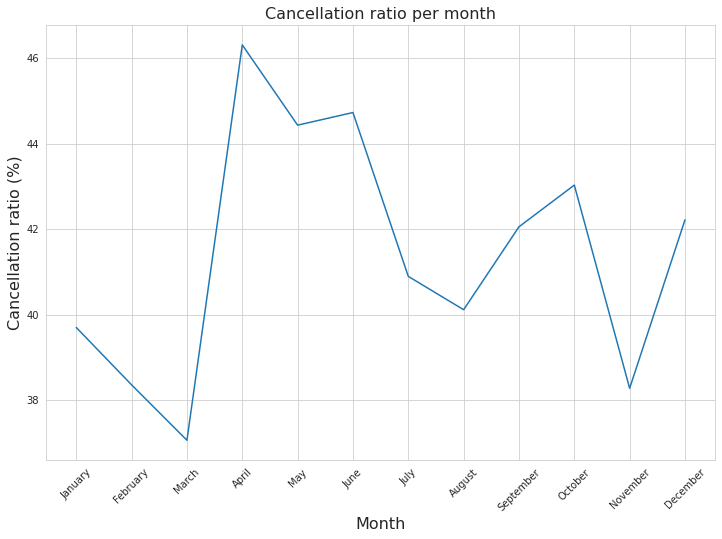


Hotel type: Resort


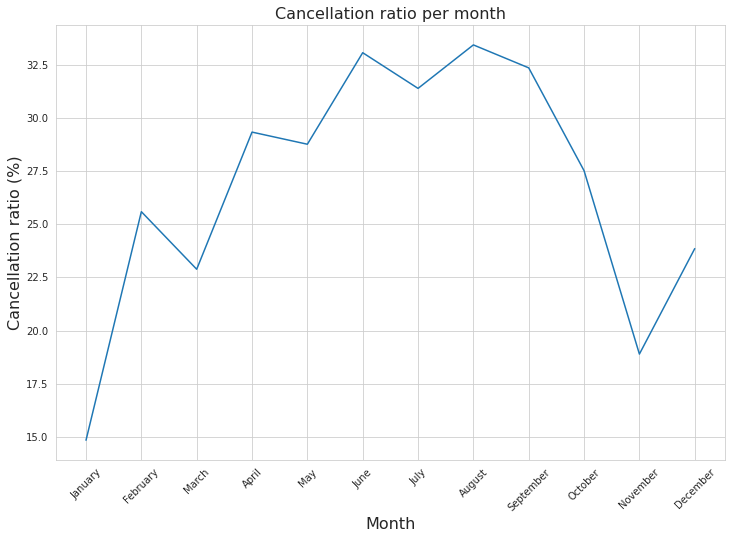

In [ ]:
show_yearly_cancellation_ratio(city, 'City')
show_yearly_cancellation_ratio(resort, 'Resort')

**Important finding**: correlation between cancellation ratio and price per person throughout the year.

In [ ]:
def print_price_canc_corr(source, hotel_type):
  corr = source['is_canceled'].corr(source['per_person'])
  print(f'Correlation for {hotel_type} hotels: {corr}')

In [ ]:
print_price_canc_corr(city, 'City')
print_price_canc_corr(resort, 'Resort')

Correlation for City hotels: -0.03199548935523307
Correlation for Resort hotels: 0.05652293915973373


maybe cancellation 0-1 values is an issue

## Collinearity as a whole

"arrival_date_year" and "arrival_date_week_number" 

"required_car_parking_spaces" and "is_cancelled"

"total_of_special_request" and "is_cancelled"

"is_repeated_guest" and "company"

"previous_booking_not_cancelled" and "company"


VIF(variance inflation factor) values:a VIF value of 5 or greater indicates significant collinearity. What are the predictor variables?

how to deal with it: consider removing one or more of the highly correlated variables from the model or combining them into a single variable. You can repeat steps 3-5 until you have resolved any collinearity issues.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
3cleaned：https://drive.google.com/uc?export=download&id=1H7tFzEhiRoXbaxEyEknZpG4Frkky72QG

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1i-JbDm2nY15NnYl62GxlsBCoELp1HJZ3")

<Axes: >

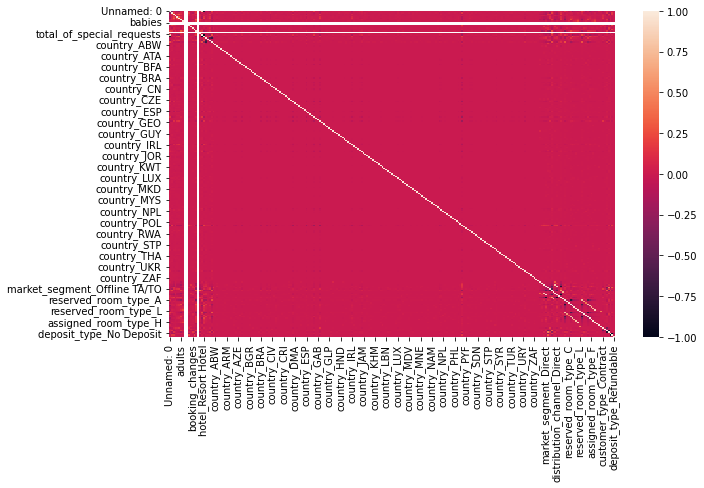

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(df.corr())

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


## Confounders

1. bivariate analyses to identify variables that are associated with both the exposure and outcome variables. You can use various statistical tests, such as chi-squared tests, t-tests, or correlation coefficients, to examine the associations.
2. causal diagrams to visualize the relationships between the exposure, outcome, and potential confounding variables.
3. multivariate regression models to estimate the effect of the exposure variable on the outcome variable, while controlling for potential confounders.

In [ ]:
df.head()

Unnamed: 0  is_canceled  lead_time arrival_date_month  \
0           2            0          7               July   
1           3            0         13               July   
2           4            0         14               July   
3           6            0          0               July   
4           7            0          9               July   

   arrival_date_week_number  stays_in_weekend_nights  stays_in_week_nights  \
0                        27                        0                     1   
1                        27                        0                     1   
2                        27                        0                     2   
3                        27                        0                     2   
4                        27                        0                     2   

   adults  children  babies  ...  assigned_room_type_I  assigned_room_type_K  \
0       1       0.0       0  ...                     0                     0   
1       1       0.0       0  ...                     0                     0   
2       2       0.0       0  ...                     0                     0   
3       2       0.0       0  ...                     0                     0   
4       2       0.0       0  ...                     0                     0   

   assigned_room_type_L  customer_type_Contract  customer_type_Group  \
0                     0                       0                    0   
1                     0                       0                    0   
2                     0                       0                    0   
3                     0                       0                    0   
4                     0                       0                    0   

   customer_type_Transient  customer_type_Transient-Party  \
0                        1                              0   
1                        1                              0   
2                        1                              0   
3                        1                              0   
4                        1                              0   

   deposit_type_No Deposit  deposit_type_Non Refund  deposit_type_Refundable  
0                        1                        0                        0  
1                        1                        0                        0  
2                        1                        0                        0  
3                        1                        0                        0  
4                        1                        0                        0  

[5 rows x 236 columns]